**Kelvin Fung**<br>
**YSC4216 Machine Learning**<br>
**Assignment 6: Gaussian Processes for Regression**

1. Generate two classes of data with the same population size (N1=N2=50), sigma = 0.1, mean_red = (2, 2) and mean_blue = (3, 3).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

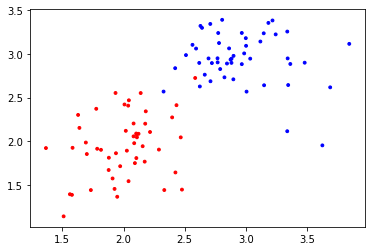

In [2]:
N1 = N2 = 50
mean_red = (2, 2)
mean_blue = (3, 3)
sigma = 0.1
cov = [[sigma, 0], [0, sigma]]

X_red = np.random.multivariate_normal(mean_red, cov, N1)
X_blue = np.random.multivariate_normal(mean_blue, cov, N2)

c1 = ['red'] * N1
c2 = ['blue'] * N2

X = np.concatenate((X_red, X_blue))
color = np.concatenate((c1, c2))

t_N = np.matrix([[0] * 50 + [1] * 50]).T

plt.scatter(X[:, 0], X[:, 1], marker='o', c=color, s=8)
plt.show()

2. Write code to classify the two clusters with Gaussian Processes.
3. Use the kernel written on p.307 of textbook. Set the parameters to (1.0, 4.0, 1.0, 2.0)

In [3]:
def get_kernel_func(thetas):
    def k(xi, xj):
        # Convert arrays into column vectors
        xi = np.matrix(xi).T
        xj = np.matrix(xj).T
        return thetas[0] * np.exp(-thetas[1]/2 * np.linalg.norm(xi-xj)**2) + \
               thetas[2] + (thetas[3]*xi.T*xj)[0, 0]
    return k

In [4]:
def get_C(X, v, k):
    length = X.shape[0]
    C = np.zeros((length, length))
    
    for row in range(length):
        for col in range(row, length):
            if row == col:
                C[row, col] = k(X[row, ], X[row, ]) + v
            else:
                temp = k(X[row, ], X[col, ])
                C[row, col] = temp
                C[col, row] = temp
    
    return C

In [5]:
def get_c_star(x_star, v, k):
    return k(x_star, x_star) + v

In [6]:
def get_k_star(x_star, X_dummy, k):
    return np.matrix([k(x_star, x) for x in X_dummy]).T

In [7]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [8]:
def get_a_N(X, t_N, C):
        
        l = X.shape[0]
        a_N = np.matrix(np.zeros((l, 1)))
        counter = 0
        sum_diff = 999

        while sum_diff > 1e-4:
            H = -np.linalg.inv(C) - get_W_N(a_N)
            nabla_g = t_N - sigmoid(a_N) - (np.linalg.inv(C) * a_N)
            a_N_new = a_N - (np.linalg.inv(H) * nabla_g)
            sum_diff = abs(sum(a_N_new - a_N))
            counter += 1
            
            a_N = a_N_new
        
        return a_N

In [9]:
def get_W_N(a_N):
    temp = sigmoid(a_N)
    temp2 = 1 - temp
    
    return np.diag(np.diag(temp * temp2.T))

In [10]:
def get_prob_blue(x_star, X_dummy, k, v, C, a_N, W_N_inv):
            
    k_star = get_k_star(x_star, X_dummy, k)
    c_star = get_c_star(x_star, v, k)

    mu_star = k_star.T * np.linalg.inv(C) * a_N
    s_star = c_star - (k_star.T * np.linalg.inv(W_N_inv + C) * k_star)

    return sigmoid(mu_star / np.power(1 + (s_star**2 * np.pi/8), 1/2))

In [11]:
v = 1
thetas = (1, 4, 1, 2)
k = get_kernel_func(thetas)

# Variables that will not depend on x_star
C = get_C(X, v, k)
a_N = get_a_N(X, t_N, C)
W_N_inv = np.linalg.inv(get_W_N(a_N))

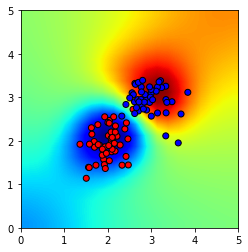

In [12]:
x_coord = np.arange(0,5,0.25)
y_coord = np.arange(0,5,0.25)

Z = np.zeros((len(x_coord),len(y_coord)))


for i in range(len(x_coord)) :
    for j in range(len(y_coord)) :
        Z[i,j] = get_prob_blue(np.matrix([x_coord[i], y_coord[j]]), X, k, v,
                                   C, a_N, W_N_inv)
        
plt.scatter(X[:,0], X[:,1], marker = 'o', c = color, edgecolor = 'black')

plt.imshow(Z, interpolation = 'bilinear', origin = 'lower', cmap = 'jet', extent=[0, 5, 0, 5])

plt.show()

5. Change the kernel parameters to (1.0, 0.25, 0, 0) to obtain:

In [13]:
v = 1
thetas = (1, 0.25, 0, 0)
k = get_kernel_func(thetas)

# Variables that will not depend on x_star
C = get_C(X, v, k)
a_N = get_a_N(X, t_N, C)
W_N_inv = np.linalg.inv(get_W_N(a_N))

In [ ]:
# Prepare values for image
n_pixels = 50

Z = np.zeros((n_pixels, n_pixels))
for col, x1 in enumerate(np.linspace(0, 5, n_pixels)):
    for row, x2 in enumerate(np.linspace(0, 5, n_pixels)):
        Z[row, col] = get_prob_blue(np.matrix([[x1, x2]]), X, k, v,
                                   C, a_N, W_N_inv)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=color, s=8)
plt.imshow(Z, interpolation='bilinear', origin='lower', cmap='jet',
           extent=[0,5,0,5])

6. Discuss why the parameters generate a less precise probability map.

The kernel equation is given by $\theta_0 exp(-\frac{\theta_1}{2} ||x_i-x_j||^2) + \theta_2 + \theta_3 x_i^Tx_j$. With the new parameters, the third and fourth values are 0. Firstly, this means that the information contained in $x_i^Tx_j$ is now gone. On a bigger picture, this means that with every new test point, the relationship between the new test point and the data points in the training set has a smaller effect on the probability, hence the probability map is less precise.

7. Change the kernel parameters back to (1.0, 4.0, 1.0, 2.0)
8. Change the means of the clusters to mean1=[3,3], mean2=[3.2,3.2] and cov1=[[0.003, 0], [0,0.003]] and cov2 = [[0.3, 0], [0, 0.3]]

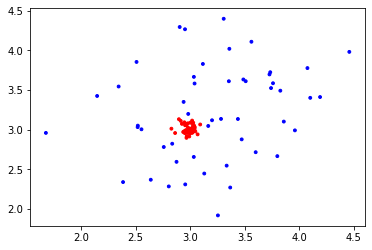

In [27]:
N1 = N2 = 50
mean_red = (3, 3)
mean_blue = (3.2, 3.2)

cov1 = [[0.003, 0], [0, 0.003]]
cov2 = [[0.3, 0], [0, 0.3]]

X_red = np.random.multivariate_normal(mean_red, cov1, N1)
X_blue = np.random.multivariate_normal(mean_blue, cov2, N2)

c1 = ['red'] * N1
c2 = ['blue'] * N2

X = np.concatenate((X_red, X_blue))
color = np.concatenate((c1, c2))

t_N = np.matrix([[0] * 50 + [1] * 50]).T

plt.scatter(X[:, 0], X[:, 1], marker='o', c=color, s=8)
plt.show()

In [38]:
v = 1
thetas = (1, 4, 1, 2)
k = get_kernel_func(thetas)

# Variables that will not depend on x_star
C = get_C(X, v, k)
a_N = get_a_N(X, t_N, C)
W_N_inv = np.linalg.inv(get_W_N(a_N))

In [29]:
# Prepare values for image
n_pixels = 100

Z = np.zeros((n_pixels, n_pixels))
for col, x1 in enumerate(np.linspace(0, 5, n_pixels)):
    for row, x2 in enumerate(np.linspace(0, 5, n_pixels)):
        Z[row, col] = get_prob_blue(np.matrix([[x1, x2]]), X, k, v,
                                   C, a_N, W_N_inv)

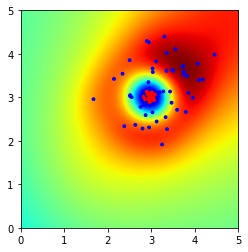

In [30]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=color, s=8)
plt.imshow(Z, interpolation='bilinear', origin='lower', cmap='jet',
           extent=[0,5,0,5])

10. Change the means and clusters back to #1 above, and add another cluster belonger to C2, with mean=[1,1] and sigma=0.1.

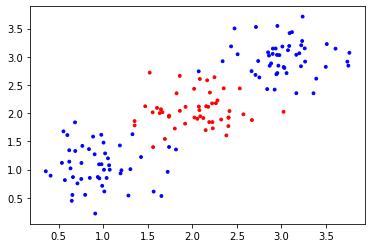

In [40]:
N1 = N2 = N3 = 50
mean_red = (2, 2)
mean_blue = (3, 3)
mean_blue2 = (1, 1)

sigma = 0.1
cov = [[sigma, 0], [0, sigma]]

X_red = np.random.multivariate_normal(mean_red, cov, N1)
X_blue = np.random.multivariate_normal(mean_blue, cov, N2)
X_blue2 = np.random.multivariate_normal(mean_blue2, cov, N3)

c1 = ['red'] * N1
c2 = ['blue'] * N2
c3 = ['blue'] * N3

X = np.concatenate((X_red, X_blue, X_blue2))
color = np.concatenate((c1, c2, c3))

t_N = np.matrix([[0] * 50 + [1] * 100]).T

plt.scatter(X[:, 0], X[:, 1], marker='o', c=color, s=8)
plt.show()

11. Classify and show the probability map.

In [41]:
v = 1
thetas = (1, 4, 1, 2)
k = get_kernel_func(thetas)

# Variables that will not depend on x_star
C = get_C(X, v, k)
a_N = get_a_N(X, t_N, C)
W_N_inv = np.linalg.inv(get_W_N(a_N))

In [42]:
# Prepare values for image
n_pixels = 50

Z = np.zeros((n_pixels, n_pixels))
for col, x1 in enumerate(np.linspace(0, 5, n_pixels)):
    for row, x2 in enumerate(np.linspace(0, 5, n_pixels)):
        Z[row, col] = get_prob_blue(np.matrix([[x1, x2]]), X, k, v,
                                   C, a_N, W_N_inv)

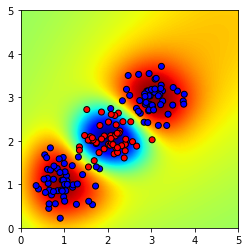

In [47]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=color, edgecolor = 'black')
plt.imshow(Z, interpolation='bilinear', origin='lower', cmap='jet',
           extent=[0,5,0,5])